In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import notebook, tnrange
# from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
# Set some parameters
im_width = 32
im_height = 128
border = 5

In [7]:
import re
def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [8]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
ids = sorted_nicely(ids)[:3000]
print("No. of images = ", len(ids))

No. of images =  3000


In [9]:
X = np.zeros((len(ids), im_width, im_height, 1), dtype=np.float32)
y = np.zeros((len(ids), im_width, im_height, 1), dtype=np.float32)

**Load the images and masks into arrays**

In [10]:
# tqdm is used to display the progress bar
for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/"+id_, color_mode="grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("masks/"+id_, color_mode="grayscale"))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0 < 0.5

In [11]:
print(np.shape(X))

(3000, 32, 128, 1)


In [12]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=False)

**Code for visualizing masks**

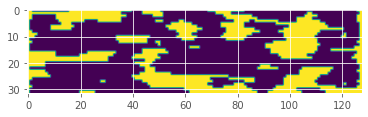

In [13]:
plt.imshow(y_valid[7][:,:,0])
# print(y_train[1][55,60,0])
# print(y_train[1][:,:,0].max())
# print(y_train[1][:,:,0].min())

Text(0.5, 1.0, 'xH')

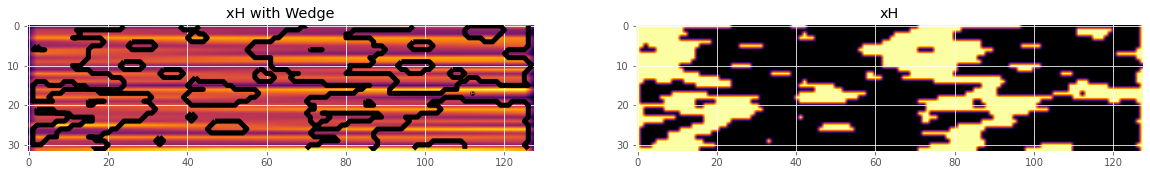

In [14]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].min() == 0 # ionized region indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'inferno', interpolation = 'bilinear')
if has_mask: # if neutral
    # draw a boundary(contour) in the original image separating neutral and ionized areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.001])
ax1.set_title('xH with Wedge')

ax2.imshow(y_train[ix].squeeze(), cmap = 'inferno', interpolation = 'bilinear')
ax2.set_title('xH')

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [17]:
input_img = Input((im_width, im_height, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 32)  320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 128, 32)  128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 128, 32)  0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [19]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 297s 124ms/step - loss: 0.6510 - accuracy: 0.6339 - val_loss: 0.6535 - val_accuracy: 0.6630

Epoch 00001: val_loss improved from inf to 0.65346, saving model to model-tgs-salt.h5
Epoch 2/50
2400/2400 [==============================] - 264s 110ms/step - loss: 0.6388 - accuracy: 0.6426 - val_loss: 0.6336 - val_accuracy: 0.6682

Epoch 00002: val_loss improved from 0.65346 to 0.63360, saving model to model-tgs-salt.h5
Epoch 3/50
2400/2400 [==============================] - 274s 114ms/step - loss: 0.6316 - accuracy: 0.6458 - val_loss: 0.6291 - val_accuracy: 0.6687

Epoch 00003: val_loss improved from 0.63360 to 0.62907, saving model to model-tgs-salt.h5
Epoch 4/50
2400/2400 [==============================] - 281s 117ms/step - loss: 0.6232 - accuracy: 0.6512 - val_loss: 0.6142 - val_accuracy: 0.6711

Epoch 00004: val_loss improved from 0.62907 to 0.61422, saving model to model-tgs-salt.h5
E

2400/2400 [==============================] - 242s 101ms/step - loss: 0.3732 - accuracy: 0.8279 - val_loss: 0.3370 - val_accuracy: 0.8485

Epoch 00037: val_loss did not improve from 0.32847
Epoch 38/50
2400/2400 [==============================] - 245s 102ms/step - loss: 0.3717 - accuracy: 0.8289 - val_loss: 0.3255 - val_accuracy: 0.8540

Epoch 00038: val_loss improved from 0.32847 to 0.32551, saving model to model-tgs-salt.h5
Epoch 39/50
2400/2400 [==============================] - 245s 102ms/step - loss: 0.3709 - accuracy: 0.8292 - val_loss: 0.3188 - val_accuracy: 0.8583

Epoch 00039: val_loss improved from 0.32551 to 0.31881, saving model to model-tgs-salt.h5
Epoch 40/50
2400/2400 [==============================] - 245s 102ms/step - loss: 0.3592 - accuracy: 0.8355 - val_loss: 0.3315 - val_accuracy: 0.8529

Epoch 00040: val_loss did not improve from 0.31881
Epoch 41/50
2400/2400 [==============================] - 247s 103ms/step - loss: 0.3644 - accuracy: 0.8334 - val_loss: 0.3375 - va

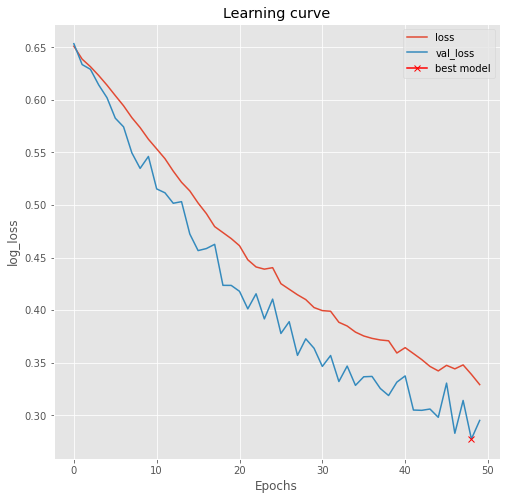

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Inference**

In [22]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [23]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 34s 57ms/step


[0.2774247395992279, 0.879071831703186]

In [24]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 31s 52ms/step


In [25]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [26]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='inferno')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.01])
    ax[0].set_title('$\Delta$T with wedge')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ionized regions without wedge')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.01])
    ax[2].set_title('Ionized regions predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.01])
    ax[3].set_title('Ionized regions predicted binary');

**Predictions on Training Set**

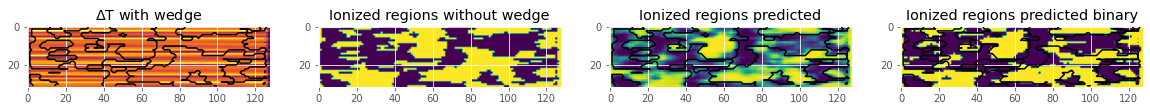

In [27]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=None)

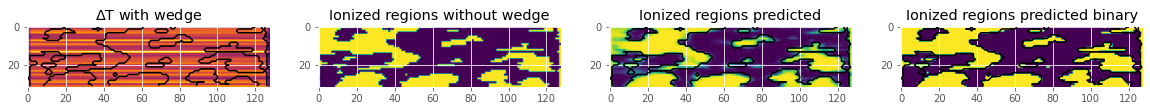

In [28]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1)

**Predictions on Test Set**

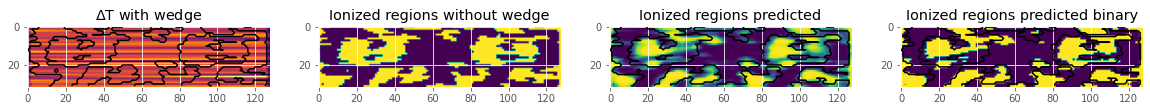

In [29]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=None)

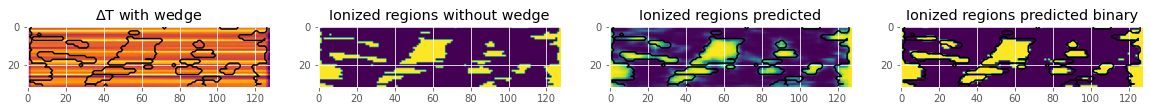

In [30]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)